The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes. The goal of the project is to cluster the data and treat them as individual datasets to train regression models to predict the mpg.

<b>DOMAIN :</b> Automobile

<b>ABOUT DATA :</b> The data concerns city-cycle fuel consumption in miles per gallon.
1. mpg: continuous
2. cylinders(cyl): multi-valued discrete
3. displacement(disp): continuous
4. horsepower(hp): continuous
5. weight(wt): continuous
6. acceleration(acc): continuous
7. model year(yr): multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

In [1]:
#Import libraries
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from scipy import stats
from scipy.stats import zscore

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading the json file and concatinating it with car names
c = pd.read_json (r'./car.json')
c1 = pd.read_csv('./Car name.csv')
car = pd.concat([c,c1],axis=1)
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
row, column = car.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 398 rows and 9 columns


In [4]:
#save this data as to csv,xlsx and json
car.to_csv('mpg.csv', index=False)
car.to_excel('mpg.xlsx', index = False)
car.to_json('mpg.json', orient = 'split', compression = 'infer', index = 'true')

In [5]:
#dropping/ignoring car_name
car = car.drop('car_name', axis=1)


# Also replacing the categorical var with actual values
car['origin'] = car['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin
0,18.0,8,307.0,130,3504,12.0,70,america
1,15.0,8,350.0,165,3693,11.5,70,america
2,18.0,8,318.0,150,3436,11.0,70,america
3,16.0,8,304.0,150,3433,12.0,70,america
4,17.0,8,302.0,140,3449,10.5,70,america


In [6]:
print('The data type of each attribute: \n')
car.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     398 non-null    float64
 1   cyl     398 non-null    int64  
 2   disp    398 non-null    float64
 3   hp      398 non-null    object 
 4   wt      398 non-null    int64  
 5   acc     398 non-null    float64
 6   yr      398 non-null    int64  
 7   origin  398 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


There are no missing values in the dataset.

In [7]:
#5-point summary
car.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0


In [8]:
#convert string to float
car['hp'] = pd.to_numeric(car['hp'],errors='coerce')

In [9]:
print('The data set has no missing values \n')
car.isnull().sum()

The data set has no missing values 



mpg       0
cyl       0
disp      0
hp        6
wt        0
acc       0
yr        0
origin    0
dtype: int64

In [10]:
car['hp'].fillna(car['hp'].median(), inplace =True)

In [11]:
#creating mpg_level attribute using the 25% and 75% of mpg values( <  17 as low, > 17 and <29 as medium, > 29 as high  )
car['mpg_level'] = car['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,mpg_level
0,18.0,8,307.0,130.0,3504,12.0,70,america,medium
1,15.0,8,350.0,165.0,3693,11.5,70,america,low
2,18.0,8,318.0,150.0,3436,11.0,70,america,medium
3,16.0,8,304.0,150.0,3433,12.0,70,america,low
4,17.0,8,302.0,140.0,3449,10.5,70,america,medium


In [12]:
#categorical variable
car_cat = car.iloc[:,[1,6,7,8]]
car_cat.head()

,cyl,yr,origin,mpg_level
0,8,70,america,medium
1,8,70,america,low
2,8,70,america,medium
3,8,70,america,low
4,8,70,america,medium


In [13]:
#numeric variables
car_num=car.drop(['cyl','yr','origin','mpg_level'],axis=1)
car_num.head()

,mpg,disp,hp,wt,acc
0,18.0,307.0,130.0,3504,12.0
1,15.0,350.0,165.0,3693,11.5
2,18.0,318.0,150.0,3436,11.0
3,16.0,304.0,150.0,3433,12.0
4,17.0,302.0,140.0,3449,10.5


In [ ]:
#plotting categorical variables
fig = plt.figure(1, (14, 8))

for i,c in enumerate(car_cat.columns):
    ax = plt.subplot(2,2,i+1)
    sns.countplot(car_cat[c], order=car_cat[c].value_counts().index)
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {c}')
    plt.tight_layout()

plt.show()

American 4 cylinder cars produced in 1973 with medium mpg level seem to dominate the dateset

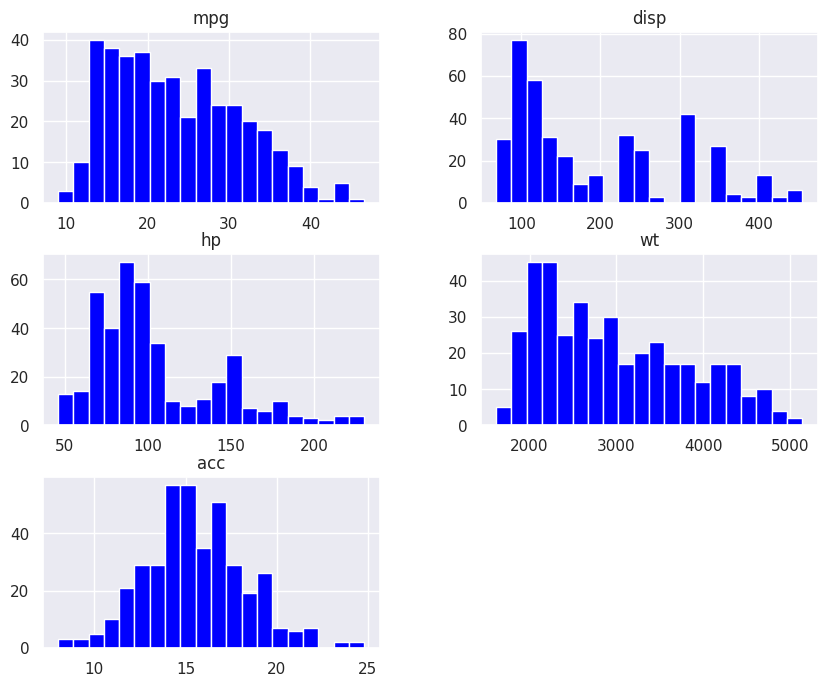

In [15]:
#plot histograms
car_num.hist(bins = 20, figsize = (10, 8), color = 'blue')
plt.show()

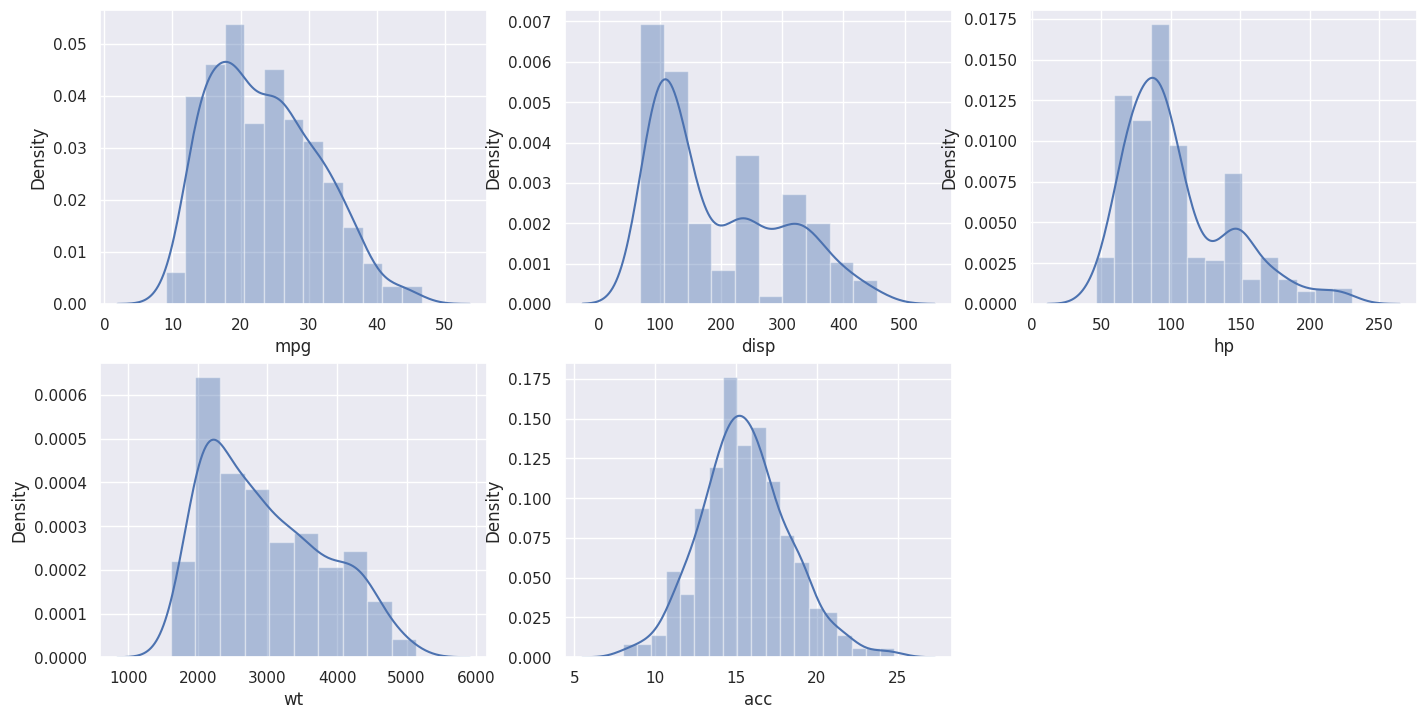

In [16]:
#plot density
plt.figure(figsize=(17, 13))
col = 1
for i in car_num.columns:
    plt.subplot(3, 3, col)
    sns.distplot(car_num[i], color = 'b')
    col += 1

Displacement and Horsepower seem to be skewed to the right

In [17]:
#checking for attribute type
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mpg        398 non-null    float64
 1   cyl        398 non-null    int64  
 2   disp       398 non-null    float64
 3   hp         398 non-null    float64
 4   wt         398 non-null    int64  
 5   acc        398 non-null    float64
 6   yr         398 non-null    int64  
 7   origin     398 non-null    object 
 8   mpg_level  398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [18]:
#create dummy varibale for mpg_level and origin and creating a seperate datset for k-means and heirarchical clustering
#car = pd.get_dummies(car, columns=['origin'])
#car = pd.get_dummies(car, columns=['mpg_level'])

lb = LabelEncoder()

car['origin'] = lb.fit_transform(car['origin'])
car['mpg_level'] = lb.fit_transform(car['mpg_level'])


car.head()

In [ ]:
carH=car.copy()
carK=car.copy()

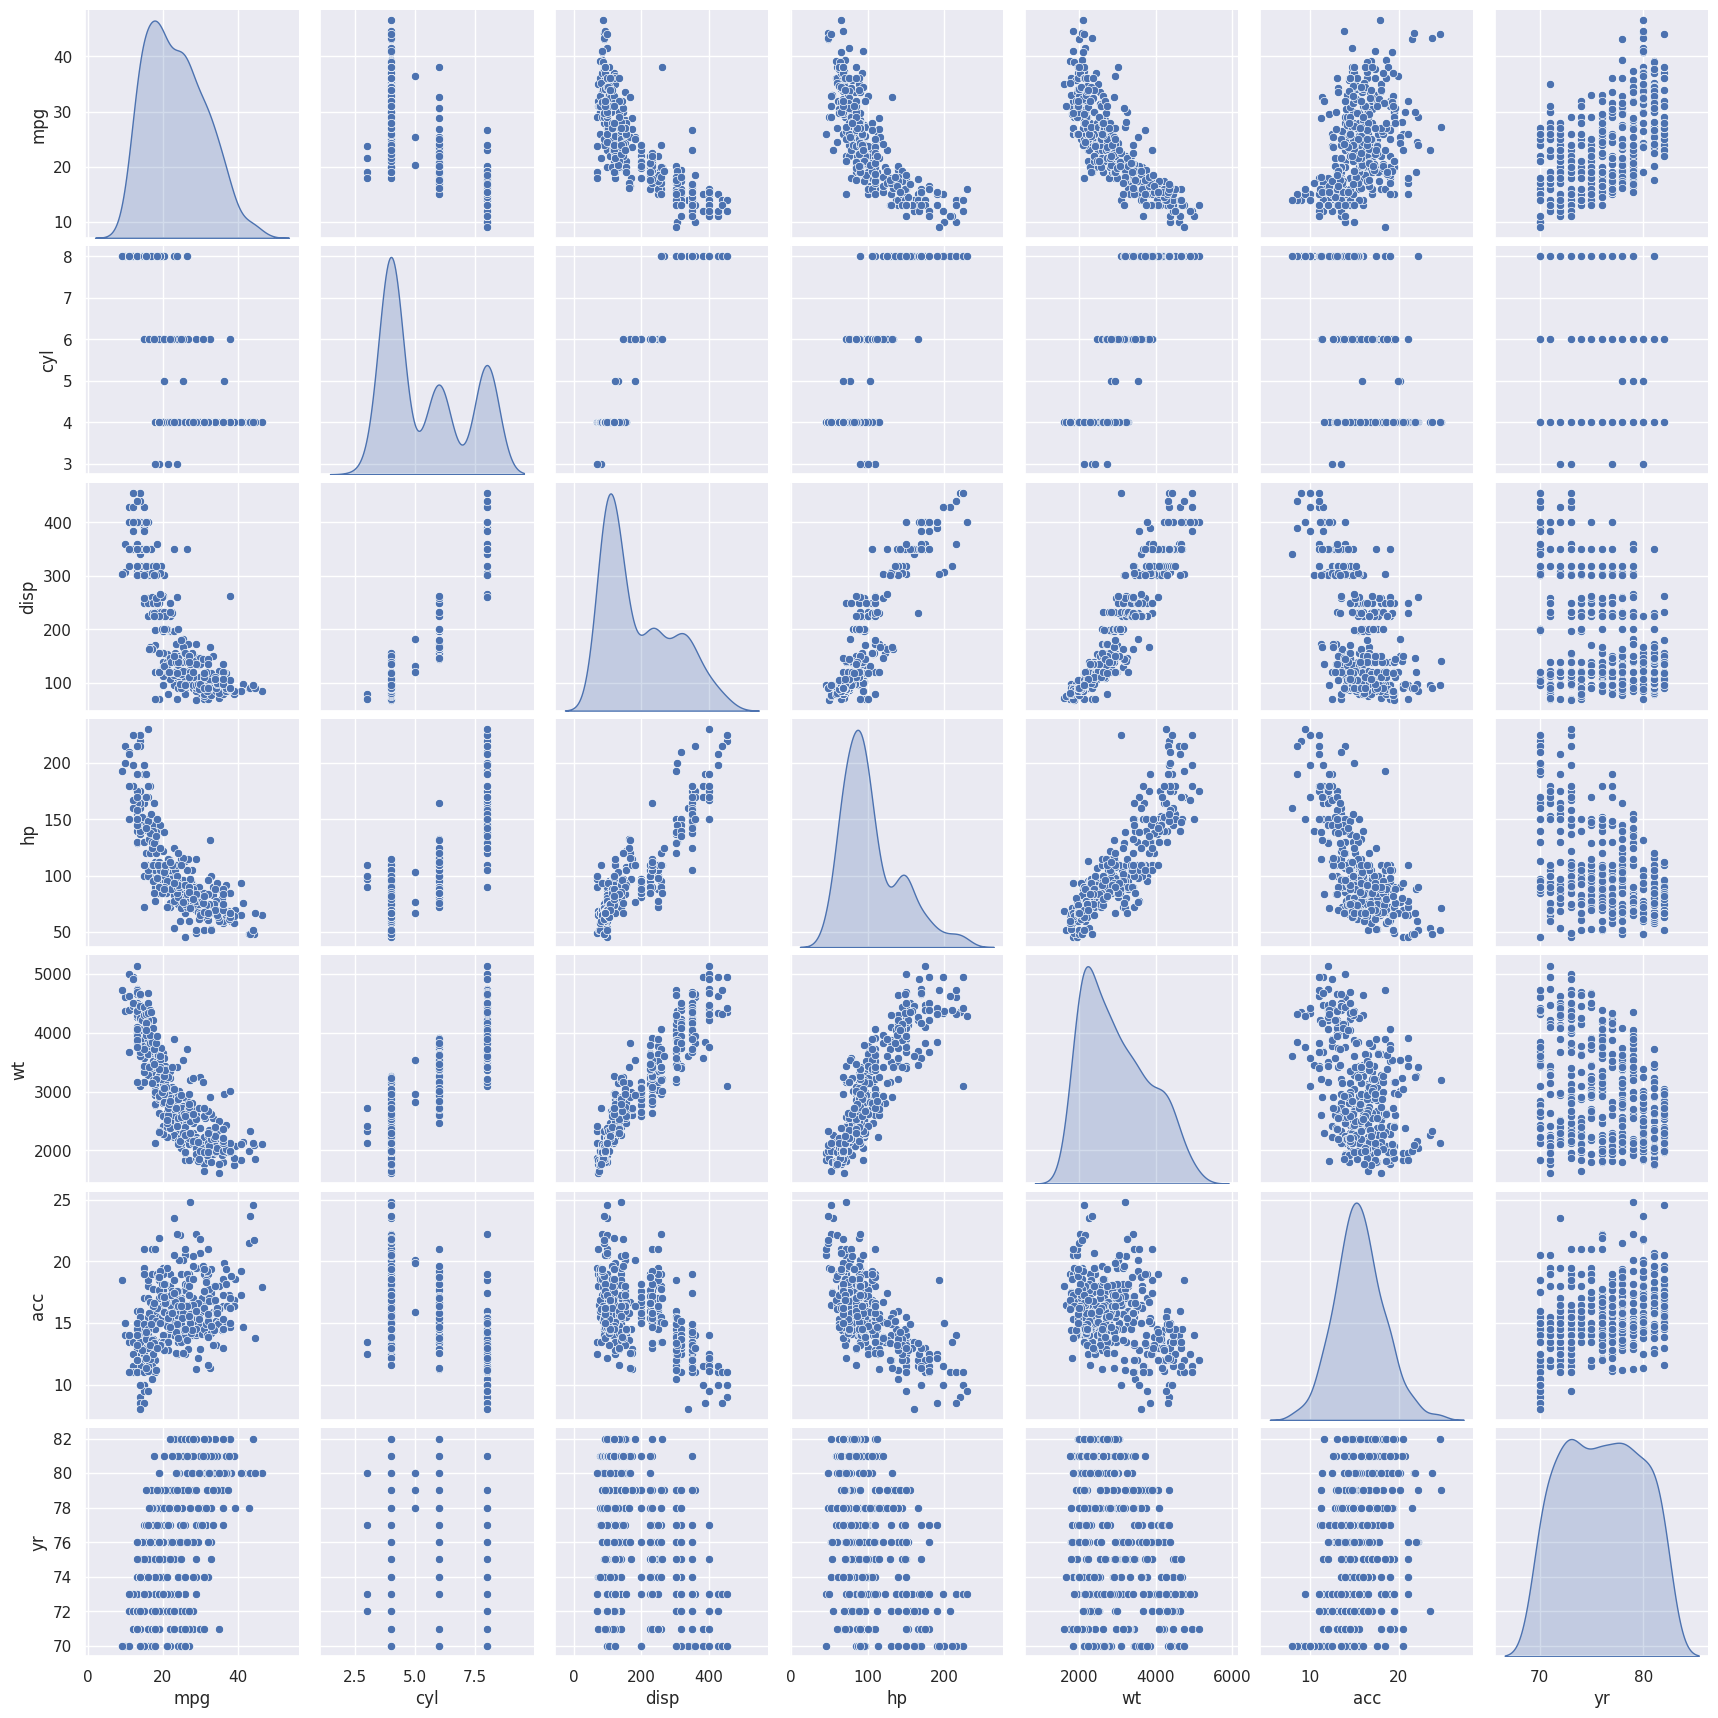

In [19]:
#pair plot for the numeric attributes
car_attr = car.iloc[:, 0:7]
sns.pairplot(car_attr, diag_kind='kde');

There appears to be a linear relationship between the variables

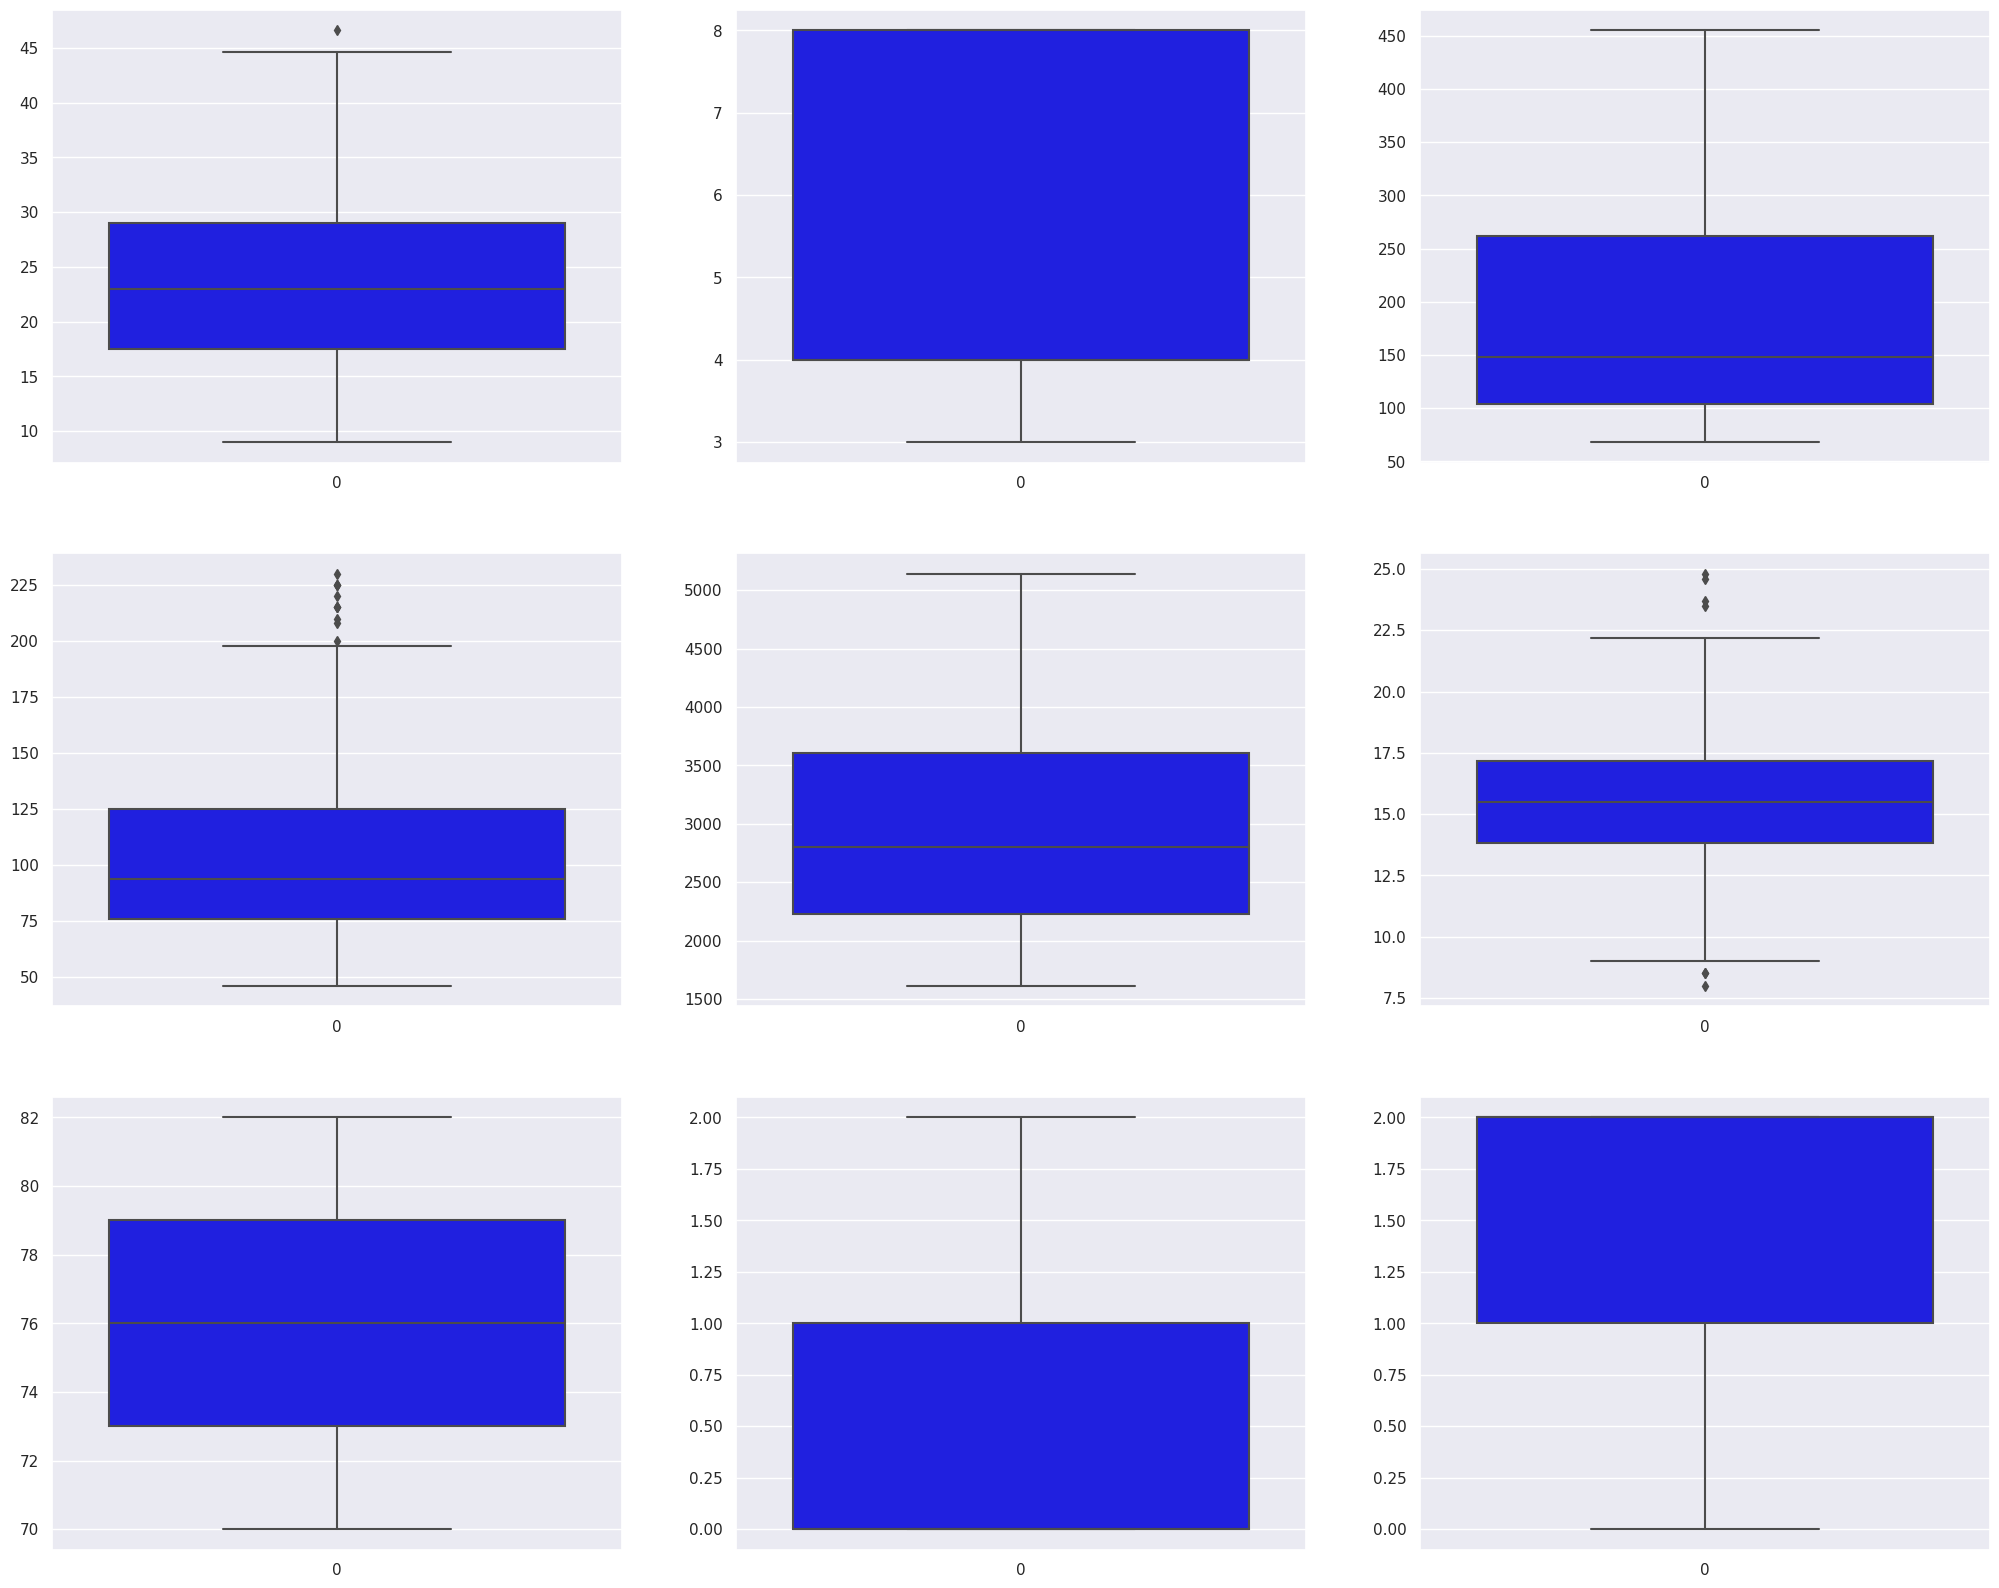

In [21]:
#checking of outliers
plt.figure(figsize=(25, 20))
col = 1
for i in car.columns:
    plt.subplot(3, 3, col)
    sns.boxplot(car[i],color='blue')
    col += 1

In [22]:
#replacing outliers with IQR (Q1 and Q3 +-1.5*IQR)
IQR1 = stats.iqr(car['hp'], interpolation = 'midpoint')
IQR2 = stats.iqr(car['acc'], interpolation = 'midpoint')

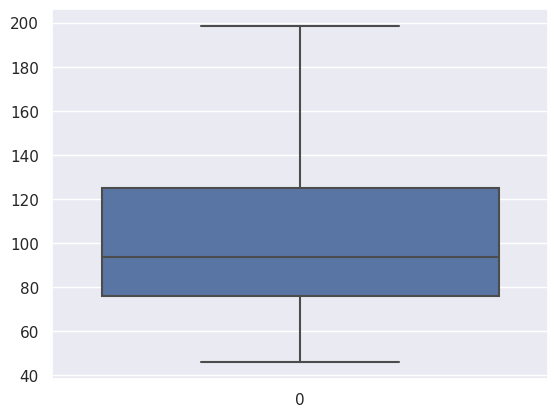

In [24]:
#Horsepower after imputing outliers
Q3 = car['hp'].quantile(0.75)
car['hp'] = np.where(car["hp"] >(Q3+1.5*IQR1), 198.5,car['hp'])
sns.boxplot(car['hp']);

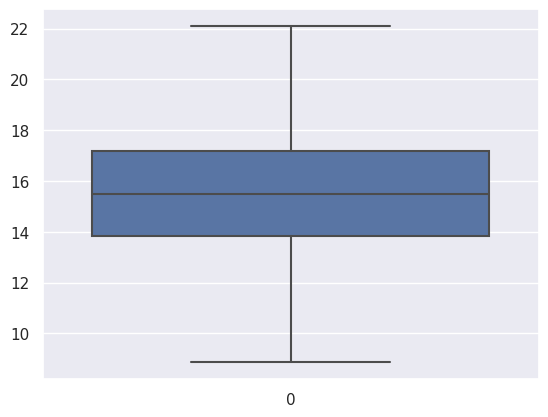

In [25]:
#accelaration after imputing outliers
Q1 = car['acc'].quantile(0.25)
Q31 = car['acc'].quantile(0.75)
car['acc'] = np.where(car["acc"] >(Q31+1.5*IQR2),22.10 ,car['acc'])
car['acc'] = np.where(car["acc"] <(Q1-1.5*IQR2),(Q1-1.5*IQR2),car['acc'])
sns.boxplot(car['acc']);

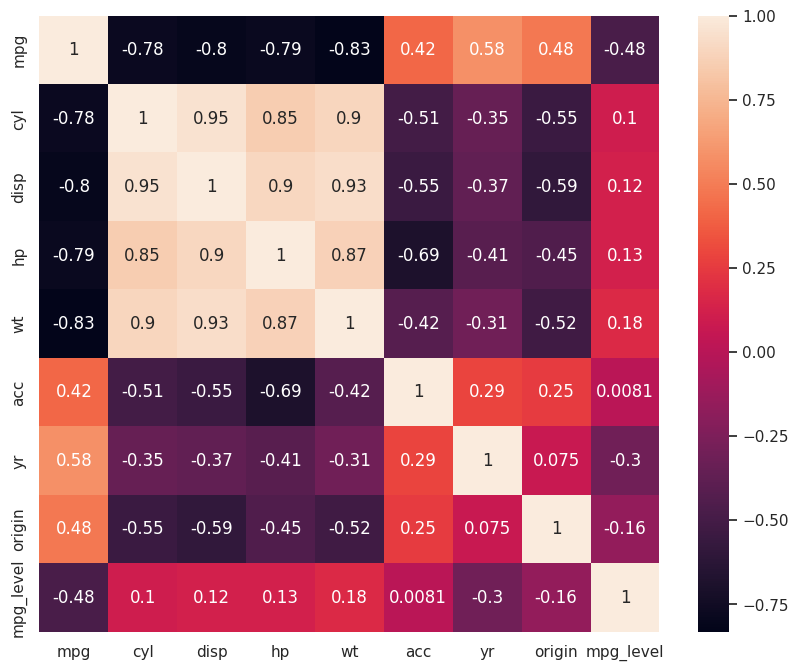

In [26]:
#checking for correlation
plt.figure(figsize=(10,8))
corr=car.corr()
sns.heatmap(corr,annot=True);

Except Year, most of the variable are correlated with each other

## Heirarchical Clustering

In [27]:
#separating numeric variables
cc = car.iloc[:,0:7]
cc.head()

,mpg,cyl,disp,hp,wt,acc,yr
0,18.0,8,307.0,130.0,3504,12.0,70
1,15.0,8,350.0,165.0,3693,11.5,70
2,18.0,8,318.0,150.0,3436,11.0,70
3,16.0,8,304.0,150.0,3433,12.0,70
4,17.0,8,302.0,140.0,3449,10.5,70


In [28]:
#scaling the variable
cc_z = cc.apply(zscore)
cc_z.head()

,mpg,cyl,disp,hp,wt,acc,yr
0,-0.706439,1.498191,1.090604,0.713692,0.630870,-1.322760,-1.627426
1,-1.090751,1.498191,1.503514,1.666741,0.854333,-1.509008,-1.627426
2,-0.706439,1.498191,1.196232,1.258291,0.550470,-1.695257,-1.627426
3,-0.962647,1.498191,1.061796,1.258291,0.546923,-1.322760,-1.627426
4,-0.834543,1.498191,1.042591,0.985992,0.565841,-1.881505,-1.627426


In [31]:
#calculating pairwise distance using average linkage method
link_method = linkage(cc_z.iloc[:,0:7], method = 'average')

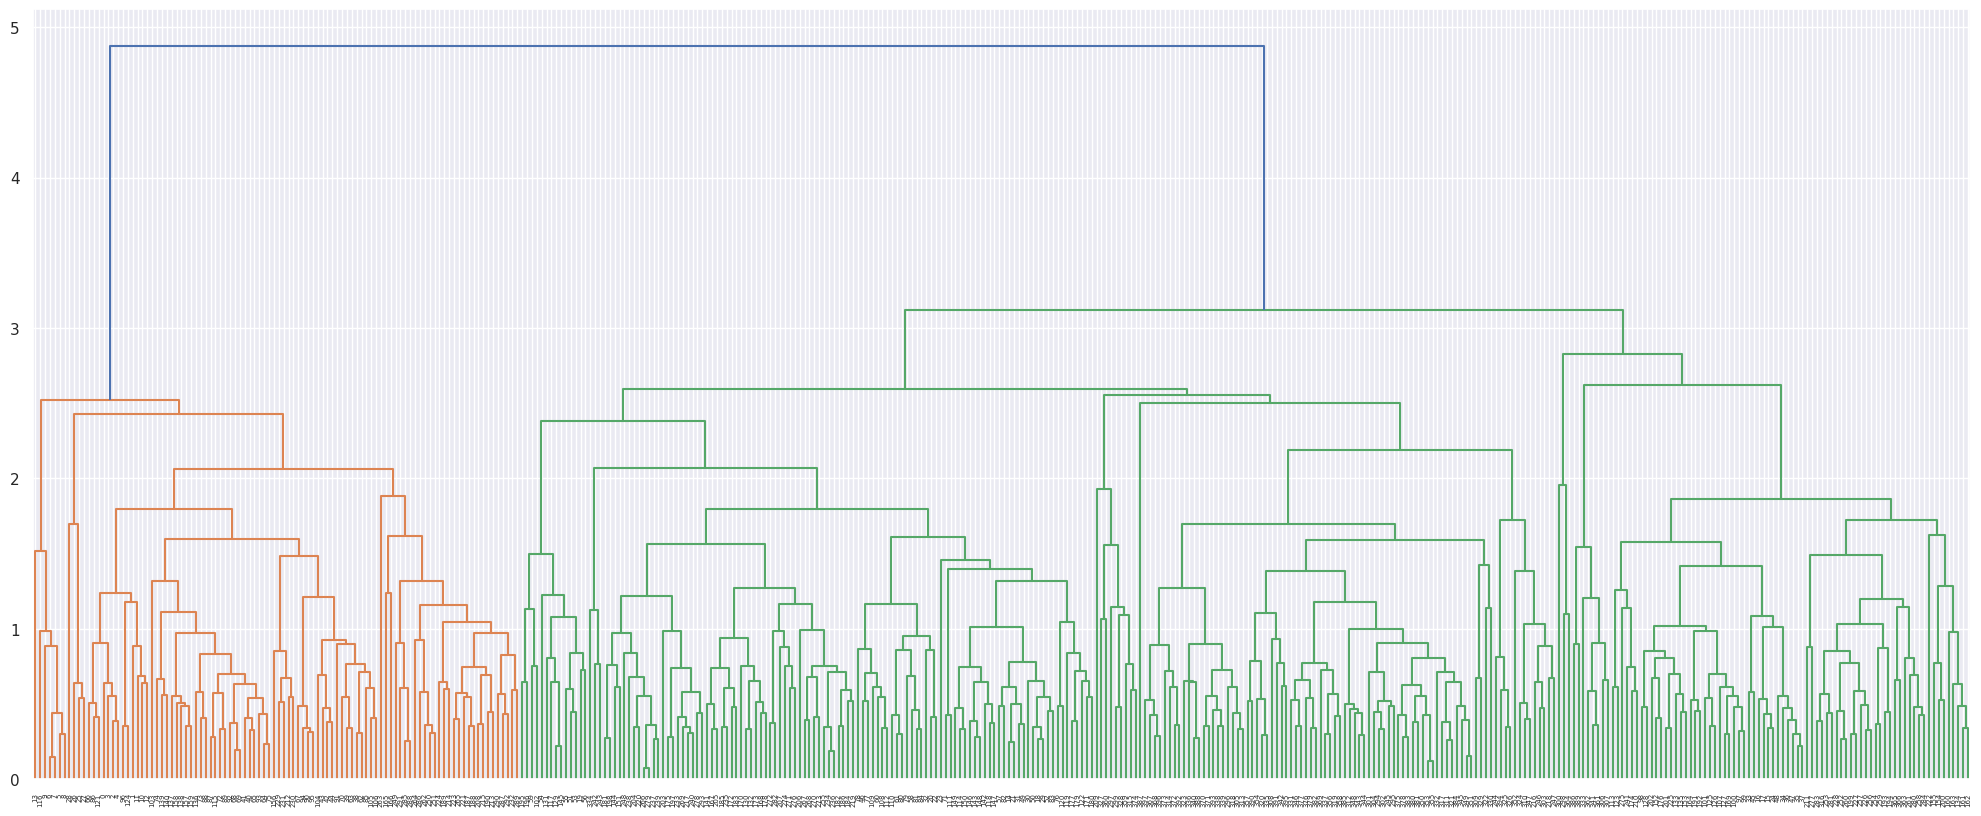

In [32]:
#plotting the H-cluster
plt.figure(figsize=(25, 10))
dendrogram(link_method)
plt.show()

Appers to be to much of a visual clutter, we'll go ahead and cut down the dendrogram to give us 2 clusters/groups

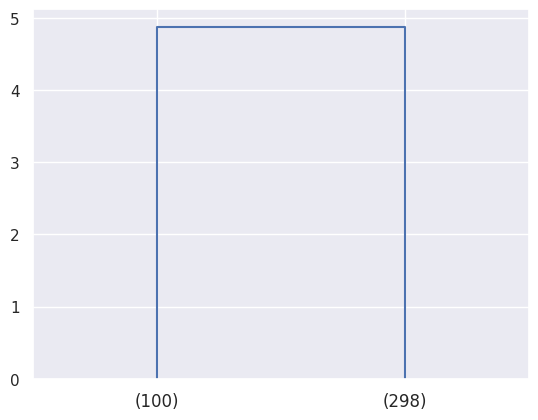

In [33]:
# dendrogram function to arrive at dendrogram
dendrogram(
    link_method,
    truncate_mode='lastp',
    p=2,
)
plt.show()

In [34]:
#vieweing the clusters formed
clusters = fcluster(link_method, 2, criterion='maxclust')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,

In [35]:
#attaching the clusters formed to the scales data
cc_z['clusters_H'] = clusters
cc_z.head()

,mpg,cyl,disp,hp,wt,acc,yr,clusters_H
0,-0.706439,1.498191,1.090604,0.713692,0.630870,-1.322760,-1.627426,1
1,-1.090751,1.498191,1.503514,1.666741,0.854333,-1.509008,-1.627426,1
2,-0.706439,1.498191,1.196232,1.258291,0.550470,-1.695257,-1.627426,1
3,-0.962647,1.498191,1.061796,1.258291,0.546923,-1.322760,-1.627426,1
4,-0.834543,1.498191,1.042591,0.985992,0.565841,-1.881505,-1.627426,1


In [36]:
#vieweing the distribution of clusters
cc_z.clusters_H.value_counts().sort_index()

1    100
2    298
Name: clusters_H, dtype: int64

In [37]:
#attaching the clusters formed to the original data
cc['clusters_H']=clusters
carH['clusters_H']=clusters
cc.head()

,mpg,cyl,disp,hp,wt,acc,yr,clusters_H
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


In [38]:
#create a new data set named Hclus
Hclus=cc
Hclus.head()

,mpg,cyl,disp,hp,wt,acc,yr,clusters_H
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


In [39]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('clusters_H').mean()
aggdata['Freq']=cc.clusters_H.value_counts().sort_index()
aggdata

,mpg,cyl,disp,hp,wt,acc,yr,Freq
clusters_H,,,,,,,,
1,14.684000,7.980000,345.470000,158.355000,4121.560000,12.718250,73.740000,100
2,26.477852,4.607383,142.404362,85.479866,2584.137584,16.501678,76.771812,298


Clearly shows two disting group with a difference in average between the clusters and variables

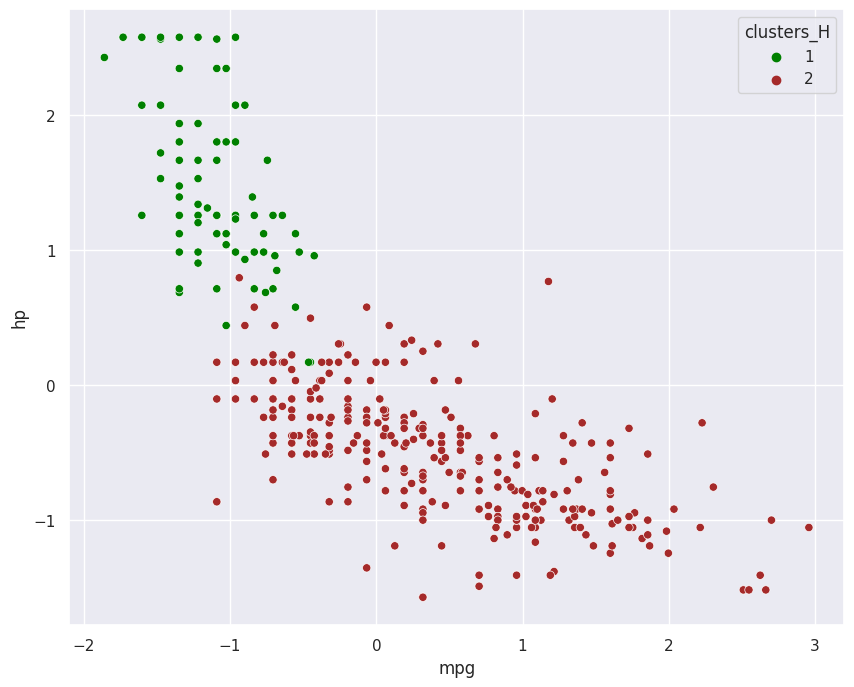

In [40]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="clusters_H",
              data=cc_z,
                    palette=['green','brown']);


## K-Means Clustering

In [41]:
#seperating the numeric values
cc = car.iloc[:,0:7]
cc_z1 = cc.apply(zscore)
cc_z1.head()

,mpg,cyl,disp,hp,wt,acc,yr
0,-0.706439,1.498191,1.090604,0.713692,0.630870,-1.322760,-1.627426
1,-1.090751,1.498191,1.503514,1.666741,0.854333,-1.509008,-1.627426
2,-0.706439,1.498191,1.196232,1.258291,0.550470,-1.695257,-1.627426
3,-0.962647,1.498191,1.061796,1.258291,0.546923,-1.322760,-1.627426
4,-0.834543,1.498191,1.042591,0.985992,0.565841,-1.881505,-1.627426


In [42]:
#calculatint the within sum of squares
wss =[]
for i in range(1,5):
    KM = KMeans(n_clusters=i)
    KM.fit(cc_z1)
    wss.append(KM.inertia_)
wss

[2785.9999999999986, 1284.4271286107846, 934.1491592677435, 726.7177631548959]

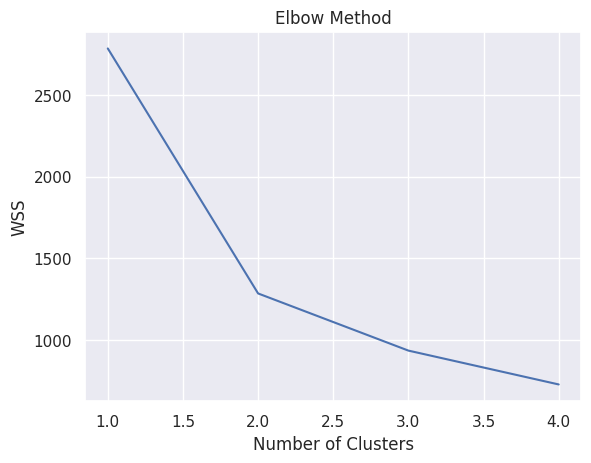

In [43]:
#plotting the WSS against the number of cluster to come up with optimal number of clusters using Elbow-method
plt.plot(range(1,5), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");


In [44]:
#using 2 centroids for clustering
k_means = KMeans(n_clusters = 2)
k_means.fit(cc_z1)
labels = k_means.labels_

In [45]:
# Calculating silhouette_score
silhouette_score(cc_z1,labels)

0.48588624948016845

In [46]:
#calculating silhouette score for different centroids
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}


silhouette_coefficients = []

 # Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cc_z1)
    score = silhouette_score(cc_z1,kmeans.labels_)
    silhouette_coefficients.append(score)




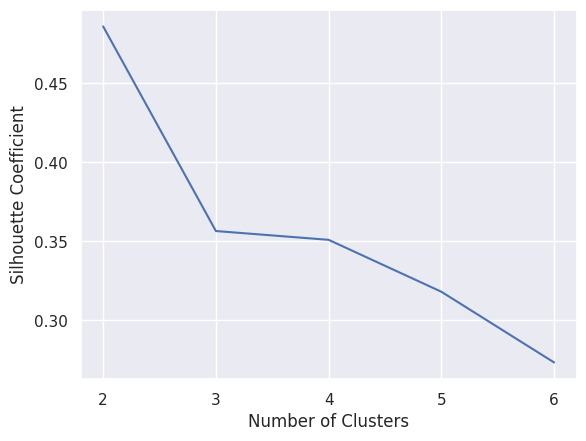

In [47]:
#plotting silhouette score for different centroids
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [48]:
#attaching the labels to the datasets
cc["cluster_K"] = labels
carK['cluster_K']=labels
Kclus=cc
Kclus.head()

,mpg,cyl,disp,hp,wt,acc,yr,cluster_K
0,18.0,8,307.0,130.0,3504,12.0,70,0
1,15.0,8,350.0,165.0,3693,11.5,70,0
2,18.0,8,318.0,150.0,3436,11.0,70,0
3,16.0,8,304.0,150.0,3433,12.0,70,0
4,17.0,8,302.0,140.0,3449,10.5,70,0


In [49]:
#vieweing the distribution of clusters
cc.cluster_K.value_counts().sort_index()

0    104
1    294
Name: cluster_K, dtype: int64

In [50]:
#attaching the clsuters to the scaled data
cc_z1["cluster_K"] = labels
cc_z1.head()

,mpg,cyl,disp,hp,wt,acc,yr,cluster_K
0,-0.706439,1.498191,1.090604,0.713692,0.630870,-1.322760,-1.627426,0
1,-1.090751,1.498191,1.503514,1.666741,0.854333,-1.509008,-1.627426,0
2,-0.706439,1.498191,1.196232,1.258291,0.550470,-1.695257,-1.627426,0
3,-0.962647,1.498191,1.061796,1.258291,0.546923,-1.322760,-1.627426,0
4,-0.834543,1.498191,1.042591,0.985992,0.565841,-1.881505,-1.627426,0


In [51]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('cluster_K').mean()
aggdata['Freq']=cc.cluster_K.value_counts().sort_index()
aggdata

,mpg,cyl,disp,hp,wt,acc,yr,Freq
cluster_K,,,,,,,,
0,14.830769,7.942308,342.692308,156.591346,4101.12500,12.857933,73.769231,104
1,26.586395,4.574830,140.624150,85.112245,2570.44898,16.503741,76.802721,294


Clearly shows two disting group with a difference in average between the clusters and variables

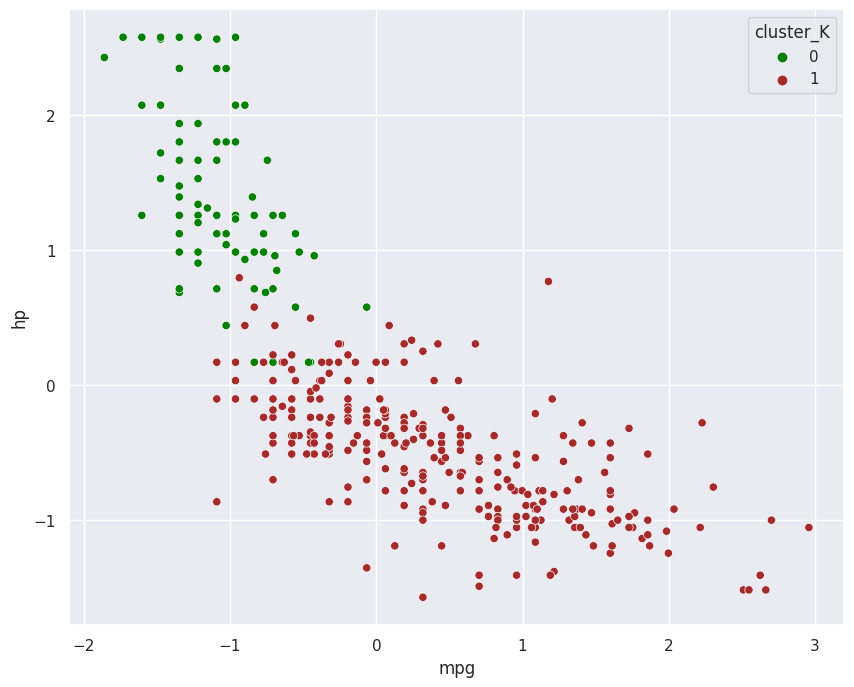

In [52]:
#plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="cluster_K",
              data=cc_z1,
                    palette=['green','brown']);

In [53]:
carH.clusters_H.value_counts().sort_index()

1    100
2    298
Name: clusters_H, dtype: int64

In [54]:
carK.cluster_K.value_counts().sort_index()

0    104
1    294
Name: cluster_K, dtype: int64

In [55]:
carH.shape

(398, 10)

In [56]:
carK.shape

(398, 10)

In [57]:
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,mpg_level
0,18.0,8,307.0,130.0,3504,12.0,70,0,2
1,15.0,8,350.0,165.0,3693,11.5,70,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,2
3,16.0,8,304.0,150.0,3433,12.0,70,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,2


## Linear regression on the original dataset

In [59]:
X = car.drop(['mpg'], axis=1)
# the dependent variable
y = car[['mpg']]

In [60]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)

In [61]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [62]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -0.42089381439709306
The coefficient for disp is 0.005454538262115142
The coefficient for hp is -0.005507032676721796
The coefficient for wt is -0.0054974698964946785
The coefficient for acc is 0.1262565164007669
The coefficient for yr is 0.590472473393488
The coefficient for origin is 0.9680513476095158
The coefficient for mpg_level is -2.451137371918775


In [63]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -2.584193771724177


In [64]:
regression_model.score(X_train, y_train)

0.8807594614202112

In [65]:
O=regression_model.score(X_test, y_test)
O

0.8831844936364353

## Linear regression on data with K means cluster

In [66]:
#renaming the cluster labels to light and heavy vehicles and creating dummy variables of it
carK['cluster_K']=carK['cluster_K'].astype('category')
carK['cluster_K'] = carK['cluster_K'].replace({1: 'heavy', 0: 'light'})
carK = pd.get_dummies(carK, columns=['cluster_K'])

In [67]:
carK.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,mpg_level,cluster_K_light,cluster_K_heavy
0,18.0,8,307.0,130.0,3504,12.0,70,0,2,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,0,1,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,0,2,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,0,1,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,0,2,1,0


In [70]:
X = carK.drop(['mpg','cluster_K_light'], axis=1)
# the dependent variable
y = carK[['mpg']]

In [71]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

In [72]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [73]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -0.8579327499802718
The coefficient for disp is 0.01306548400809688
The coefficient for hp is -0.01737715672409544
The coefficient for wt is -0.005756594070090571
The coefficient for acc is 0.14218890645057694
The coefficient for yr is 0.6049958359501038
The coefficient for origin is 0.8426603613744407
The coefficient for mpg_level is -2.5071790346584937
The coefficient for cluster_K_heavy is -1.6227252386658348


In [74]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 0.30245906894850094


In [75]:
regression_model.score(X_train, y_train)

0.8729067888220144

In [76]:
K=regression_model.score(X_test, y_test)
K

0.9016143174321677

## Linear regression on data with H-clusters

In [77]:
#renaming the cluster labels to light and heavy vehicles and creating summy variable of it
carH['clusters_H']=carH['clusters_H'].astype('category')
carH['clusters_H'] = carH['clusters_H'].replace({1: 'heavy', 2: 'light'})
carH = pd.get_dummies(carH, columns=['clusters_H'])

In [80]:
X = carH.drop(['mpg','clusters_H_light'], axis=1)
# the dependent variable
y = carH[['mpg']]

In [79]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

In [81]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [82]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -0.8372243535459944
The coefficient for disp is 0.015172515400819486
The coefficient for hp is -0.023769057645162836
The coefficient for wt is -0.00573783643864924
The coefficient for acc is 0.10678189864021617
The coefficient for yr is 0.5913427638030782
The coefficient for origin is 1.0659485127153943
The coefficient for mpg_level is -2.504498046746223
The coefficient for cluster_K_heavy is -1.2436115772437268


In [83]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 1.7755363551443892


In [84]:
regression_model.score(X_train, y_train)

0.8831842784065983

In [85]:
H=regression_model.score(X_test, y_test)
H

0.8761836821951436

In [86]:
modellists = []
modellists.append(['Linear Regression on Original Data set', O*100])
modellists.append(['Linear Regression with K means clusters', K*100])
modellists.append(['Linear Regression with Heirarchical clusters', H*100])
mdl_df = pd.DataFrame(modellists, columns = ['Model','r^2 on Test'])
mdl_df

,Model,r^2 on Test
0,Linear Regression on Original Data set,88.318449
1,Linear Regression with K means clusters,90.161432
2,Linear Regression with Heirarchical clusters,87.618368


## Summary
K-means appears to explain the highest variation in the datset, but with a difference of only 1% when compared with other models, to get more clarity a larger dataset may be used, since this is a dataset of used cars it doesn't give us how many previous owners has the cars seen which might be helful variable,the gender of the previous owners, the reason/purpose that the cars were being used is also an important factor which the dataset doen't capture. With the above mentioned features it may be possible to get a higher accuracy or explainability of the models and its variables.